In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc, precision_score
import scipy.stats

import seaborn as sns

import sys
DROPBOX = '/Users/hongjian/Dropbox (CGC)/'
sys.path.append(DROPBOX + 'analysis/info/')
sys.path.append(DROPBOX + 'analysis/utils/')
from info import *
from utils import *

%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; 

<IPython.core.display.Javascript object>

# compare confusion matrix

In [3]:
def plot_multi_confusion_matrix(df, y_true, dataset, save=False,
                                class_names = ['damage_negative', 'damage_positive']):
    '''take a dataframe with predictors and y_true value, output multiple confusion matrix plot
    '''
    
    # add PDmis columns
    df['PDmis'] = np.where((df['CADD_phred'] >= 15) & (df['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd20':('CADD_phred', 20),
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHM':('FATHMM_converted_rankscore', 0.8235),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_0.05':('cnn_prob', 0.05), 'cnn_best_0.56':('cnn_prob', 0.56),
              'PDmis': ('PDmis', 0.5)}
    
    y_preds, y_algos = [], []
    for key, (col, threshold) in col_dict.items():
        y_algos.append(key)
        y_preds.append(convert2binary(df, col, threshold))

    infos = []
    for y_pred, y_algo in zip(y_preds, y_algos):
        # Compute confusion matrix
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cnf_matrix = confusion_matrix(y_true, y_pred)
        fdr = 1 - precision_score(y_true, y_pred)
        np.set_printoptions(precision=2)

        title = '../figure/' + dataset + y_algo + '.png'
        # Plot non-normalized confusion matrix
        figure_title = 'Confusion matrix, without normalization\n{}\n{}\n accuracy: {:.2f}\n f1: {:.2f}\n'.format(
            dataset, y_algo, accuracy, f1)
        fig = plt.figure(figsize = (5,5))
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              title=figure_title)
        
        if save:
            infos.append([y_algo, accuracy, f1, fdr])
            fig.savefig(title)
            plt.close()
        else:
            plt.show()
    labels = ['Col', 'accuracy', 'f1', 'FDR']            
    df = pd.DataFrame(infos,columns=labels)
    display(df)

def convert2binary(df, col, threshold):
    '''take a dataframe, col to compare, threshold, return the binary vector
        convert to more elegent lambda function way 
        http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
    '''
    values = np.array(df[col].values)
    index = values >= threshold
    values[index] = 1
    values[~index] = 0
    return values

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=45)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
class_names = ['damage_negative', 'damage_positive'] # 0 for 'damage_negative', 1 for 'damage_positive'

validation = '../data/output/output_data_mode4.csv'
fname = validation
df = pd.read_csv(fname)
df = df[df.training==0]
y_true = df.pop('target')
dataset = 'validation(20% HGMD,DiscovEHR)'
plot_multi_confusion_matrix(df, y_true, dataset, save=True)

/Users/hongjian/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (52,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Col,accuracy,f1,FDR
0,PDmis,0.654849,0.706568,0.248109
1,PP2-HVAR,0.657023,0.690322,0.210090
2,cnn_0.7,0.938963,0.950562,0.039683
3,FATHM,0.754348,0.782080,0.124834
4,eigen_pred10,0.517057,0.398584,0.108108
5,cnn_0.05,0.865385,0.902151,0.174967
6,cadd20,0.743144,0.819337,0.270270
7,cnn_0.6,0.941806,0.953451,0.048839
8,cnn_0.5,0.941973,0.953973,0.056168
9,cnn_0.4,0.939632,0.952693,0.068426


In [5]:
fname = '../data/ExAC_nonTCGA_missense_all.anno.rare_30000.reformat.cnn.csv'
df = pd.read_csv(fname)
y_true = df.pop('target')
dataset = 'ExAC random selected 30000'
plot_multi_confusion_matrix(df, y_true, dataset, save=True)

/Users/hongjian/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


,Col,accuracy,f1,FDR
0,PDmis,0.634994,0.0,1.0
1,PP2-HVAR,0.712600,0.0,1.0
2,cnn_0.7,0.920620,0.0,1.0
3,FATHM,0.852607,0.0,1.0
4,eigen_pred10,0.938894,0.0,1.0
5,cnn_0.05,0.603674,0.0,1.0
6,cadd20,0.439637,0.0,1.0
7,cnn_0.6,0.899947,0.0,1.0
8,cnn_0.5,0.881241,0.0,1.0
9,cnn_0.4,0.861096,0.0,1.0


In [6]:
fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.reformat.cnn.csv',
          '../data/metaSVM/metaSVM_test2.anno.rare.reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.reformat.cnn.csv']

for fname in fnames:
    df = pd.read_csv(fname)
    y_true = df.pop('target')
    dataset = fname.split('_')[-1].split('.')[0]
    print dataset
    plot_multi_confusion_matrix(df, y_true, dataset, save=True)


test1


,Col,accuracy,f1,FDR
0,PDmis,0.731544,0.701493,0.356164
1,PP2-HVAR,0.691275,0.640625,0.388060
2,cnn_0.7,0.832215,0.747475,0.026316
3,FATHM,0.744966,0.612245,0.189189
4,eigen_pred10,0.630872,0.303797,0.333333
5,cnn_0.05,0.825503,0.805970,0.260274
6,cadd20,0.711409,0.718954,0.402174
7,cnn_0.6,0.859060,0.796117,0.023810
8,cnn_0.5,0.872483,0.819048,0.022727
9,cnn_0.4,0.885906,0.844037,0.041667


/Users/hongjian/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


test2


,Col,accuracy,f1,FDR
0,PDmis,0.687537,0.639562,0.436736
1,PP2-HVAR,0.709904,0.634032,0.398743
2,cnn_0.7,0.903923,0.866901,0.098609
3,FATHM,0.843091,0.797330,0.227359
4,eigen_pred10,0.694484,0.378276,0.203341
5,cnn_0.05,0.770736,0.761418,0.375921
6,cadd20,0.634076,0.641785,0.493188
7,cnn_0.6,0.905448,0.872748,0.119623
8,cnn_0.5,0.902482,0.872239,0.143262
9,cnn_0.4,0.896213,0.867410,0.167982


addtest1


,Col,accuracy,f1,FDR
0,PDmis,0.727344,0.755577,0.276092
1,PP2-HVAR,0.728134,0.738147,0.241044
2,cnn_0.7,0.913445,0.915860,0.049014
3,FATHM,0.831684,0.838638,0.141939
4,eigen_pred10,0.607709,0.446519,0.097924
5,cnn_0.05,0.825432,0.857863,0.241810
6,cadd20,0.711502,0.770774,0.331185
7,cnn_0.6,0.920061,0.923833,0.060795
8,cnn_0.5,0.921517,0.926522,0.074688
9,cnn_0.4,0.920182,0.926458,0.089180


addtest2


,Col,accuracy,f1,FDR
0,PDmis,0.726690,0.760669,0.264831
1,PP2-HVAR,0.724375,0.741150,0.231750
2,cnn_0.7,0.912181,0.917423,0.047760
3,FATHM,0.830380,0.842125,0.135364
4,eigen_pred10,0.595688,0.447996,0.094856
5,cnn_0.05,0.828594,0.863980,0.232161
6,cadd20,0.717035,0.779853,0.317330
7,cnn_0.6,0.918992,0.925309,0.059261
8,cnn_0.5,0.920183,0.927668,0.073276
9,cnn_0.4,0.918728,0.927488,0.087532


train


,Col,accuracy,f1,FDR
0,PDmis,0.753497,0.769624,0.260899
1,PP2-HVAR,0.754387,0.753619,0.223857
2,cnn_0.7,0.930633,0.930087,0.037278
3,FATHM,0.824199,0.821486,0.142819
4,eigen_pred10,0.626335,0.453455,0.092331
5,cnn_0.05,0.832909,0.859525,0.244432
6,cadd20,0.737093,0.782403,0.320227
7,cnn_0.6,0.938327,0.939116,0.048824
8,cnn_0.5,0.941378,0.942988,0.059223
9,cnn_0.4,0.941633,0.944086,0.071967


In [7]:
fname = '../data/case_control/case.anno.rare.reformat.cnn.csv'
test_set = ['CHD', 'ASD', 'DDD', 'CDH', 'EE', 'ID']
df_pos = pd.read_csv(fname)
df_pos = df_pos[df_pos['disease'].isin(test_set)]

fname = '../data/case_control/control_1911.anno.rare.reformat.cnn.csv'
test_set = ['SSC']
df_neg = pd.read_csv(fname)
df_neg = df_neg[df_neg['disease'].isin(test_set)]

df = pd.concat([df_pos, df_neg])
y_true = df.pop('target')
print y_true.shape
dataset = 'case+1911control'
plot_multi_confusion_matrix(df, y_true, dataset, save=True)

(4728,)


,Col,accuracy,f1,FDR
0,PDmis,0.460025,0.573718,0.154528
1,PP2-HVAR,0.392978,0.483813,0.160948
2,cnn_0.7,0.241751,0.205276,0.164260
3,FATHM,0.277496,0.275964,0.144547
4,eigen_pred10,0.227792,0.168148,0.145833
5,cnn_0.05,0.479272,0.595066,0.147904
6,cadd20,0.605541,0.733989,0.157498
7,cnn_0.6,0.258672,0.242817,0.163690
8,cnn_0.5,0.274535,0.273613,0.155556
9,cnn_0.4,0.293993,0.312320,0.154961


In [8]:
fname = '../data/cancer_hotspots/hotspot.anno.rare.reformat.cnn.csv'
df = pd.read_csv(fname)
y_true = df.pop('target')
dataset = 'cancer missense hotspot'
plot_multi_confusion_matrix(df, y_true, dataset, save=True)

,Col,accuracy,f1,FDR
0,PDmis,0.455882,0.626263,0.0
1,PP2-HVAR,0.360294,0.529730,0.0
2,cnn_0.7,0.242647,0.390533,0.0
3,FATHM,0.235294,0.380952,0.0
4,eigen_pred10,0.080882,0.149660,0.0
5,cnn_0.05,0.514706,0.679612,0.0
6,cadd20,0.610294,0.757991,0.0
7,cnn_0.6,0.257353,0.409357,0.0
8,cnn_0.5,0.286765,0.445714,0.0
9,cnn_0.4,0.308824,0.471910,0.0


# ROC

In [9]:
def plot_roc(df, y_true, label):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    algos = ['cnn_prob', 'MetaSVM_rankscore', 'MetaLR_rankscore', 'M-CAP_rankscore', 
             'DANN_rankscore','CADD_phred', 'Eigen-phred','Polyphen2_HVAR_rankscore', 
             'MutationTaster_converted_rankscore', 'FATHMM_converted_rankscore', 
             'fathmm-MKL_coding_rankscore']
    for algo in algos:
        index = df[algo]!=0
        y_score = df.ix[index][algo].values
        y_true_nomissing = y_true[index]

        fpr[algo], tpr[algo], _ = roc_curve(y_true_nomissing, y_score)
        roc_auc[algo] = auc(fpr[algo], tpr[algo])
    # jump comes from missing value

    plt.figure(figsize = (10,10))
    lw = 2
    for algo in algos:
        plt.plot(fpr[algo], tpr[algo], lw=lw, 
                 label='{} ROC curve (area = {:.2f})'.format(algo, roc_auc[algo]))

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of ' + label)
    plt.legend(loc="lower right", fontsize = 'medium')
    plt.show()
    
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters based on distance
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'dist' : pd.Series(abs(tpr-fpr), index=i), 'threshold' : pd.Series(threshold, index=i),
                        'fpr':pd.Series(fpr, index=i), 'tpr':pd.Series(tpr, index=i)})
    roc_t = roc.ix[roc.dist.argsort()]
    return roc_t.tail(3)

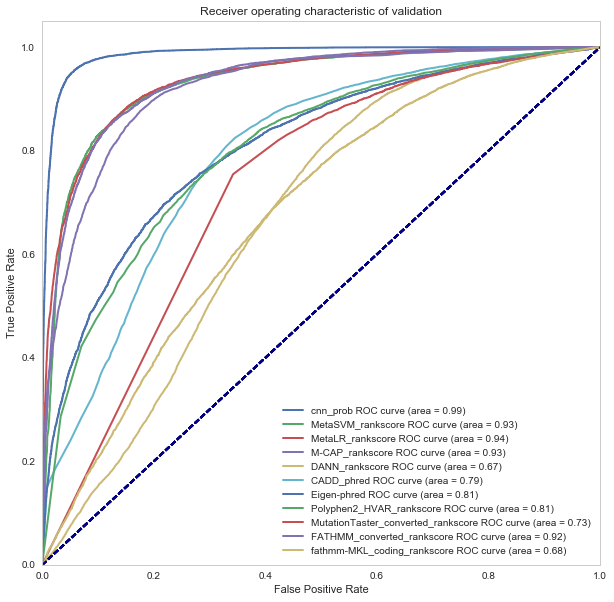

,dist,fpr,threshold,tpr
5905,0.897678,0.057209,0.638535,0.954887
5911,0.897717,0.057653,0.633838,0.955370
5912,0.897824,0.057653,0.633687,0.955477


In [10]:
class_names = ['damage_negative', 'damage_positive']
fname = validation
df = pd.read_csv(fname)
y_true = df.pop('target')
plot_roc(df, y_true, label = 'validation')
Find_Optimal_Cutoff(y_true, df['cnn_prob'])

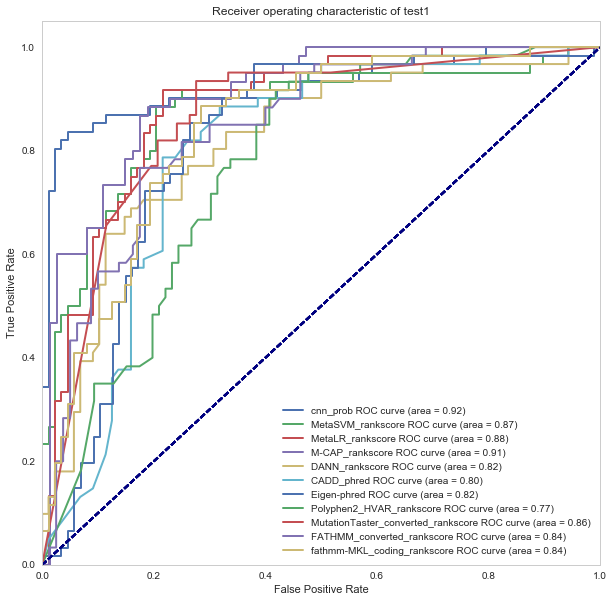

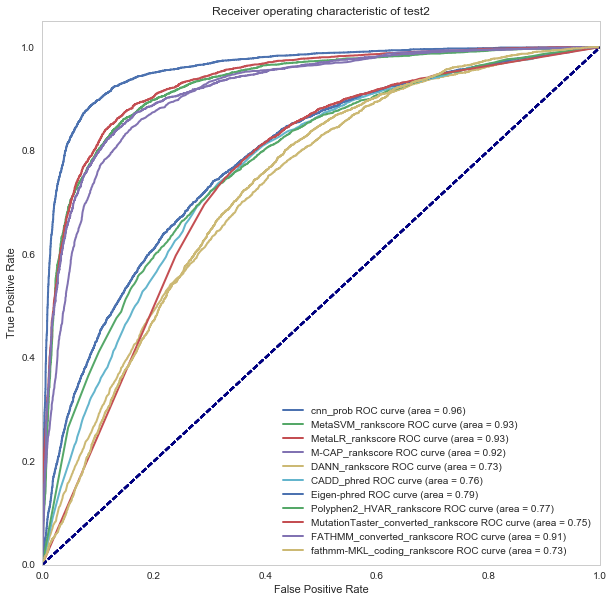

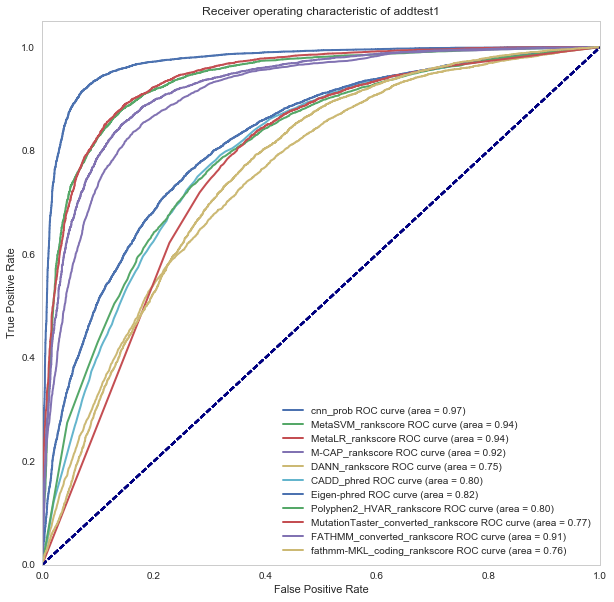

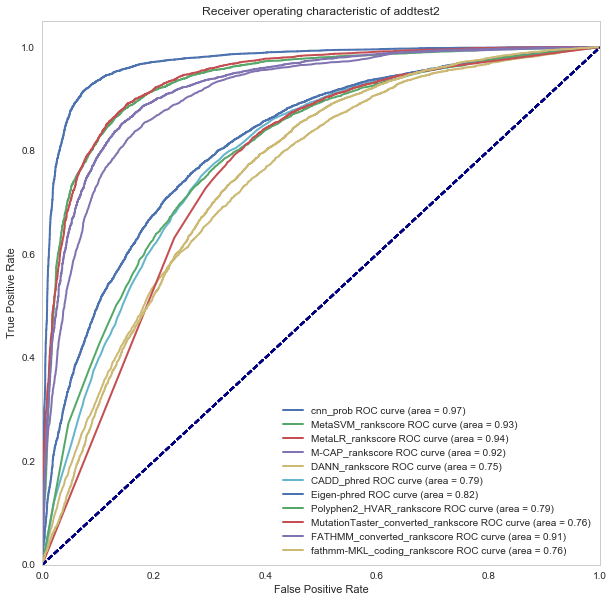

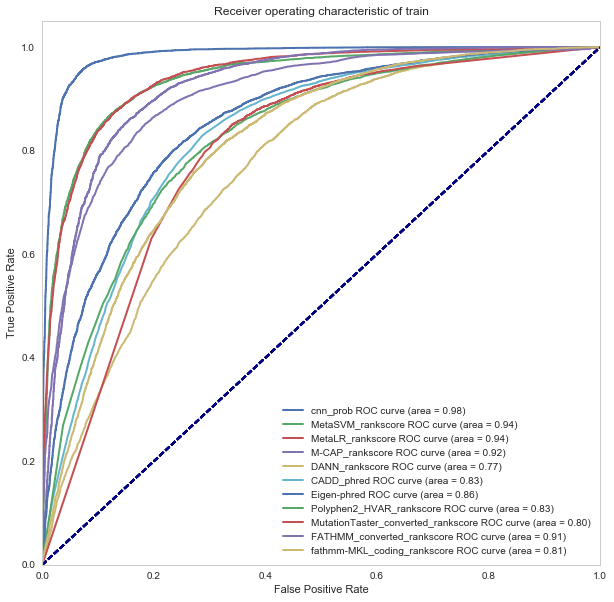

In [11]:
# metaSVM test
fnames = ['../data/metaSVM/metaSVM_test1.anno.rare.reformat.cnn.csv',
          '../data/metaSVM/metaSVM_test2.anno.rare.reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest1.anno.rare.reformat.cnn.csv',
          '../data/metaSVM/metaSVM_addtest2.anno.rare.reformat.cnn.csv',
          '../data/metaSVM/metaSVM_train.anno.rare.reformat.cnn.csv']
labels = []
for fname in fnames:
    labels.append(fname.split('_')[-1].split('.')[0])
    
for fname, lable in zip(fnames, labels):
    df = pd.read_csv(fname)
    #df = df[df['MetaSVM_rankscore']!=0]
    y_true = df.pop('category')
    index = y_true == 'TP'
    y_true[index] = 1
    y_true[~index] = 0
    y_true = y_true.astype(int)
    plot_roc(df, y_true, lable)

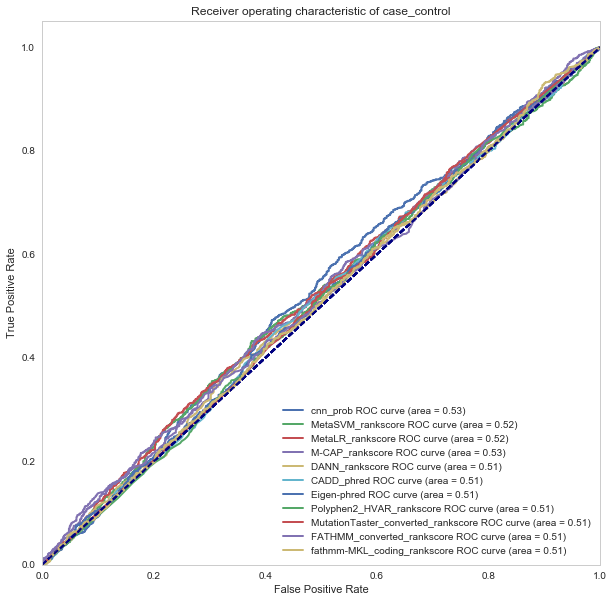

In [12]:
fname = '../data/case_control/case.anno.rare.reformat.cnn.csv'
test_set = ['CHD', 'ASD', 'DDD', 'CDH', 'EE', 'ID']
df_pos = pd.read_csv(fname)
df_pos = df_pos[df_pos['disease'].isin(test_set)]

fname = '../data/case_control/control_1911.anno.rare.reformat.cnn.csv'
test_set = ['SSC']
df_neg = pd.read_csv(fname)
df_neg = df_neg[df_neg['disease'].isin(test_set)]

df = pd.concat([df_pos, df_neg])
y_true = df.pop('target')
plot_roc(df, y_true, 'case_control')

# enrichment

In [21]:
def display_enrichment(case_info, control_info, case_disease, sort_key='Col'):
    
    print case_disease
    df_case, case_disease, disease_size = case_info 
    df_control, control_disease, disease_size = control_info 
    case_size = 0.0
    for disease in case_disease:
        if disease in disease_size:
            case_size += disease_size[disease]
    control_size = 0.0
    for disease in control_disease:
        control_size += disease_size[disease]
    print 'case size:{} control size:{}'.format(case_size, control_size)
    
    # add PDmis columns
    df_case['PDmis'] = np.where((df_case['CADD_phred'] >= 15) & (df_case['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    df_control['PDmis'] = np.where((df_control['CADD_phred'] >= 15) & (df_control['Polyphen2_HDIV_rankscore'] >= 0.52875) , 1, 0)
    # 'M-CAP_rankscore', 0.4815 is 0.025 cutoff 0.642 is 0.05 cutoff
    col_dict={'cadd15':('CADD_phred', 15), 'cadd20':('CADD_phred', 20),
              'cadd25':('CADD_phred', 25), 'cadd30':('CADD_phred', 30),
              'eigen_pred10':('Eigen-phred', 10), 'eigen_pred15':('Eigen-phred', 15),
              'eigen_pc_pred10':('Eigen-PC-phred', 10), 
              'MetaSVM>0':('MetaSVM_rankscore', 0.82271),'MetaLR>0':('MetaLR_rankscore', 0.81122), 
              'M_CAP>0.025':('M-CAP_rankscore', 0.4815), 'M_CAP>0.05':('M-CAP_rankscore', 0.642), 
              'PP2-HVAR':('Polyphen2_HVAR_rankscore', 0.6280),'FATHM':('FATHMM_converted_rankscore', 0.8235),
              'all_missense':('cnn_prob', 0.0),'cnn_0.05':('cnn_prob', 0.05),
              'cnn_0.1':('cnn_prob', 0.1), 'cnn_0.2':('cnn_prob', 0.2),
              'cnn_0.3':('cnn_prob', 0.3), 'cnn_0.4':('cnn_prob', 0.4),
              'cnn_0.5':('cnn_prob', 0.5), 'cnn_0.6':('cnn_prob', 0.6),
              'cnn_0.7':('cnn_prob', 0.7), 'cnn_0.8':('cnn_prob', 0.8),
              'cnn_best_0.56':('cnn_prob', 0.56),
              'PDmis': ('PDmis', 0.5)}
    
    infos = [] 
    for col_name, (col, threshold) in col_dict.items():
        case_count = np.sum(convert2binary(df_case, col, threshold))
        control_count = np.sum(convert2binary(df_control, col, threshold))
        total_counts = case_count + control_count
        #control_count = max(control_count, 1)
        enrich = float(case_count) / case_size / (float(control_count) / control_size)
        pvalue = scipy.stats.binom_test(case_count, total_counts,
                                            case_size / (case_size + control_size))
        risk_gene = case_count * (enrich - 1) / enrich
        #enrich = max(enrich, 1)
        tpr = (enrich - 1) / enrich
        infos.append([col_name, case_count, control_count, enrich, pvalue, risk_gene, tpr])
        
    
    labels = ['Col', 'Case', 'Control', 'enrich', 'pvalue', '# risk gene', 'true positive rate']            
    df = pd.DataFrame(infos,columns=labels)
    df = df.sort_values(by=sort_key, ascending=True)
    display(df)
    plot_rate_vs_riskvariants(df, title=','.join(case_disease))
    return df

def plot_rate_vs_riskvariants(df, title):
    x = list(df['true positive rate'])
    y = list(df['# risk gene'])
    methods = list(df['Col'])
    fig, ax = plt.subplots(figsize = (15,10))
    ax.scatter(x, y, s=100)
    for i, txt in enumerate(methods):
        if 'cnn' in txt:
            color = 'red'
        elif 'all_missense' in txt:
            color = 'blue'
        else:
            color = 'black'
        ax.annotate(txt, (x[i],y[i]), fontsize=15, color=color)
    ax.set_xlim(0)
    ax.set_xlabel('true positive rate', fontsize=15)
    ax.set_ylabel('# risk gene', fontsize=15)
    ax.set_title(title, fontsize=15)  

['CHD']
case size:2779.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate
4,FATHM,219.0,108.0,1.394416,0.004823,61.945055,0.282854
22,M_CAP>0.025,602.0,336.0,1.232053,0.002221,113.384615,0.188347
18,M_CAP>0.05,400.0,211.0,1.303616,0.001739,93.161172,0.232903
21,MetaLR>0,249.0,126.0,1.358942,0.005281,65.769231,0.264133
19,MetaSVM>0,245.0,127.0,1.326583,0.009673,60.315018,0.246184
0,PDmis,544.0,312.0,1.198992,0.011076,90.285714,0.165966
2,PP2-HVAR,441.0,256.0,1.184597,0.030915,68.721612,0.155831
1,all_missense,1248.0,766.0,1.120361,0.013440,134.073260,0.107430
20,cadd15,903.0,549.0,1.131065,0.023197,104.637363,0.115877
7,cadd20,813.0,478.0,1.169593,0.006538,117.886447,0.145002


['CDH']
case size:378.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate
4,FATHM,37.0,108.0,1.731996,5.080310e-03,15.637363,0.422631
22,M_CAP>0.025,115.0,336.0,1.730324,1.228282e-06,48.538462,0.422074
18,M_CAP>0.05,77.0,211.0,1.844918,1.099102e-05,35.263736,0.457971
21,MetaLR>0,39.0,126.0,1.564815,2.040001e-02,14.076923,0.360947
19,MetaSVM>0,37.0,127.0,1.472878,4.497292e-02,11.879121,0.321057
0,PDmis,106.0,312.0,1.717593,4.720569e-06,44.285714,0.417790
2,PP2-HVAR,73.0,256.0,1.441623,7.381047e-03,22.362637,0.306337
1,all_missense,232.0,766.0,1.531187,4.343430e-08,80.483516,0.346912
20,cadd15,162.0,549.0,1.491803,1.648461e-05,53.406593,0.329670
7,cadd20,150.0,478.0,1.586471,2.055936e-06,55.450549,0.369670


['ASD']
case size:3953.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate
4,FATHM,284.0,108.0,1.271243,0.035472,60.596546,0.213368
22,M_CAP>0.025,799.0,336.0,1.149586,0.033820,103.967033,0.130121
18,M_CAP>0.05,545.0,211.0,1.248671,0.005852,108.535845,0.199148
21,MetaLR>0,335.0,126.0,1.285311,0.016977,74.362637,0.221978
19,MetaSVM>0,315.0,127.0,1.199059,0.084667,52.294087,0.166013
0,PDmis,759.0,312.0,1.176037,0.015831,113.612245,0.149687
2,PP2-HVAR,588.0,256.0,1.110379,0.174198,58.451073,0.099407
1,all_missense,1777.0,766.0,1.121483,0.008172,192.490319,0.108323
20,cadd15,1291.0,549.0,1.136810,0.011991,155.365777,0.120345
7,cadd20,1140.0,478.0,1.152951,0.008650,151.232862,0.132660


['EE']
case size:264.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate
4,FATHM,18.0,108.0,1.206439,0.415688,3.080063,0.171115
22,M_CAP>0.025,48.0,336.0,1.034091,0.814624,1.582418,0.032967
18,M_CAP>0.05,30.0,211.0,1.029190,0.843821,0.850863,0.028362
21,MetaLR>0,21.0,126.0,1.206439,0.447245,3.593407,0.171115
19,MetaSVM>0,20.0,127.0,1.139943,0.612496,2.455259,0.122763
0,PDmis,53.0,312.0,1.229640,0.172437,9.897959,0.186754
2,PP2-HVAR,34.0,256.0,0.961381,0.928308,-1.365777,-0.040170
1,all_missense,106.0,766.0,1.001691,0.958680,0.178964,0.001688
20,cadd15,80.0,549.0,1.054810,0.625697,4.156986,0.051962
7,cadd20,70.0,478.0,1.060051,0.646910,3.965463,0.056649


['ID']
case size:192.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate
4,FATHM,13.0,108.0,1.198061,0.526327,2.149137,0.165318
22,M_CAP>0.025,38.0,336.0,1.125651,0.472549,4.241758,0.111625
18,M_CAP>0.05,23.0,211.0,1.084938,0.650959,1.800628,0.078288
21,MetaLR>0,16.0,126.0,1.263889,0.380091,3.340659,0.208791
19,MetaSVM>0,15.0,127.0,1.175566,0.558441,2.240188,0.149346
0,PDmis,34.0,312.0,1.084635,0.640418,2.653061,0.078031
2,PP2-HVAR,28.0,256.0,1.088623,0.679667,2.279435,0.081408
1,all_missense,81.0,766.0,1.052484,0.633477,4.039246,0.049867
20,cadd15,62.0,549.0,1.124032,0.361800,6.841444,0.110346
7,cadd20,59.0,478.0,1.228524,0.134121,10.974882,0.186015


['DDD']
case size:1133.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate
4,FATHM,76.0,108.0,1.186918,0.253511,11.968603,0.157482
22,M_CAP>0.025,210.0,336.0,1.054170,0.565020,10.791209,0.051387
18,M_CAP>0.05,134.0,211.0,1.071157,0.540421,8.901622,0.066430
21,MetaLR>0,93.0,126.0,1.244925,0.108505,18.296703,0.196739
19,MetaSVM>0,88.0,127.0,1.168718,0.259884,12.703820,0.144362
0,PDmis,195.0,312.0,1.054170,0.581503,10.020408,0.051387
2,PP2-HVAR,156.0,256.0,1.027816,0.798959,4.221873,0.027063
1,all_missense,441.0,766.0,0.971048,0.633908,-13.148613,-0.029815
20,cadd15,331.0,549.0,1.016919,0.807263,5.507064,0.016638
7,cadd20,292.0,478.0,1.030352,0.681993,8.601779,0.029458


['CHD', 'CDH', 'ASD', 'EE', 'ID', 'DDD']
case size:8699.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate
4,FATHM,647.0,108.0,1.316048,0.007925,155.376766,0.240150
22,M_CAP>0.025,1812.0,336.0,1.184705,0.004169,282.505495,0.155908
18,M_CAP>0.05,1209.0,211.0,1.258738,0.001868,248.513867,0.205553
21,MetaLR>0,753.0,126.0,1.312852,0.004288,179.439560,0.238300
19,MetaSVM>0,720.0,127.0,1.245432,0.022502,141.887493,0.197066
0,PDmis,1691.0,312.0,1.190640,0.004364,270.755102,0.160115
2,PP2-HVAR,1320.0,256.0,1.132727,0.071358,154.670853,0.117175
1,all_missense,3885.0,766.0,1.114176,0.006000,398.116693,0.102475
20,cadd15,2829.0,549.0,1.132014,0.007704,329.915228,0.116619
7,cadd20,2524.0,478.0,1.159986,0.002760,348.111983,0.137921


['DDD_new']
case size:4293.0 control size:1911.0


,Col,Case,Control,enrich,pvalue,# risk gene,true positive rate
4,FATHM,348.0,108.0,1.434350,0.000954,105.381476,0.302820
22,M_CAP>0.025,982.0,336.0,1.300984,0.000025,227.186813,0.231351
18,M_CAP>0.05,672.0,211.0,1.417707,0.000006,197.995290,0.294636
21,MetaLR>0,426.0,126.0,1.505008,0.000039,142.945055,0.335552
19,MetaSVM>0,404.0,127.0,1.416046,0.000495,118.698587,0.293808
0,PDmis,899.0,312.0,1.282640,0.000127,198.102041,0.220358
2,PP2-HVAR,715.0,256.0,1.243271,0.002777,139.904239,0.195670
1,all_missense,1935.0,766.0,1.124481,0.005937,214.205651,0.110701
20,cadd15,1469.0,549.0,1.191103,0.000429,235.689168,0.160442
7,cadd20,1288.0,478.0,1.199466,0.000607,214.188383,0.166295


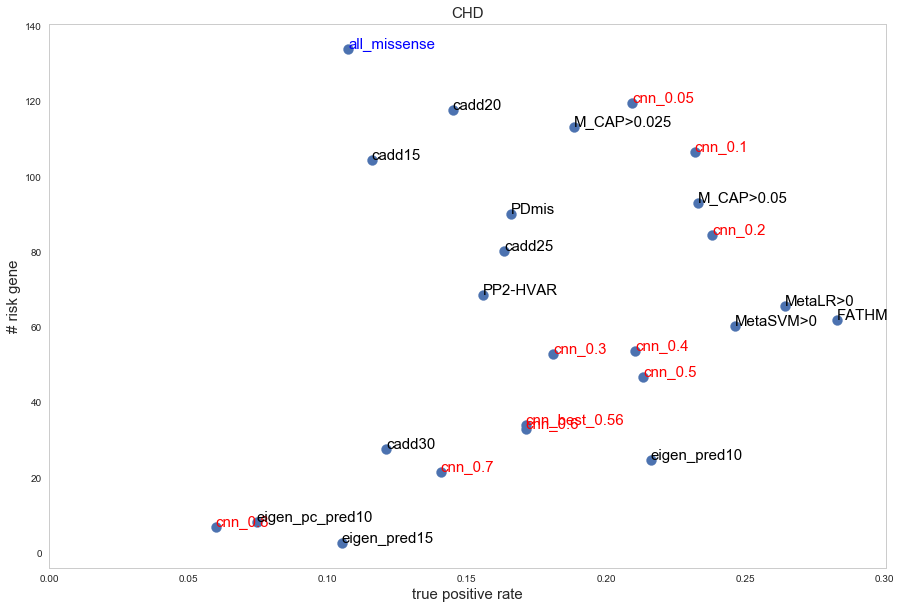

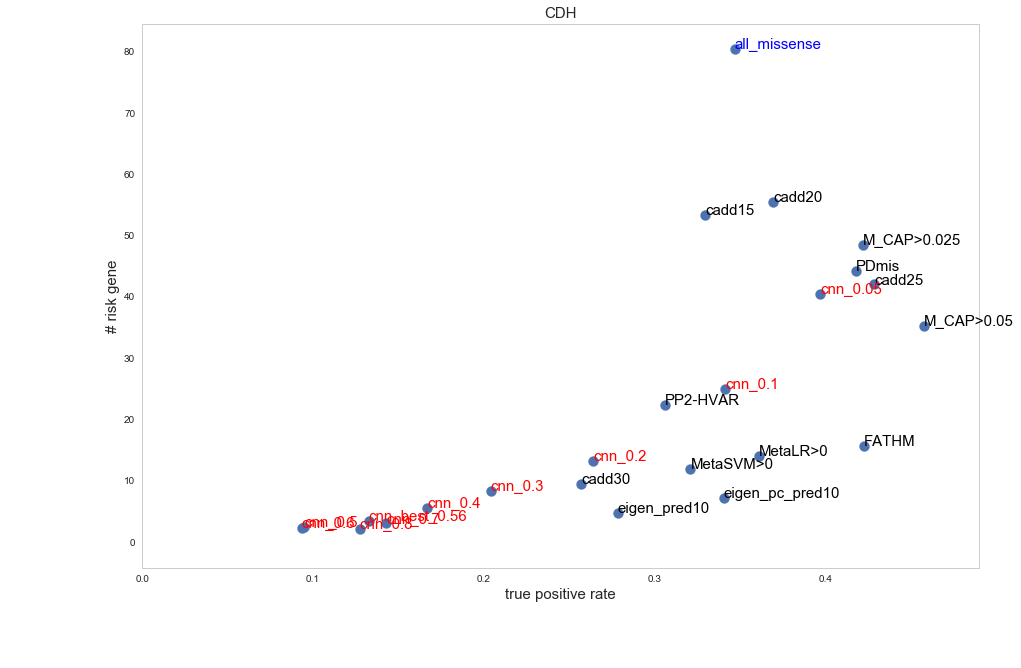

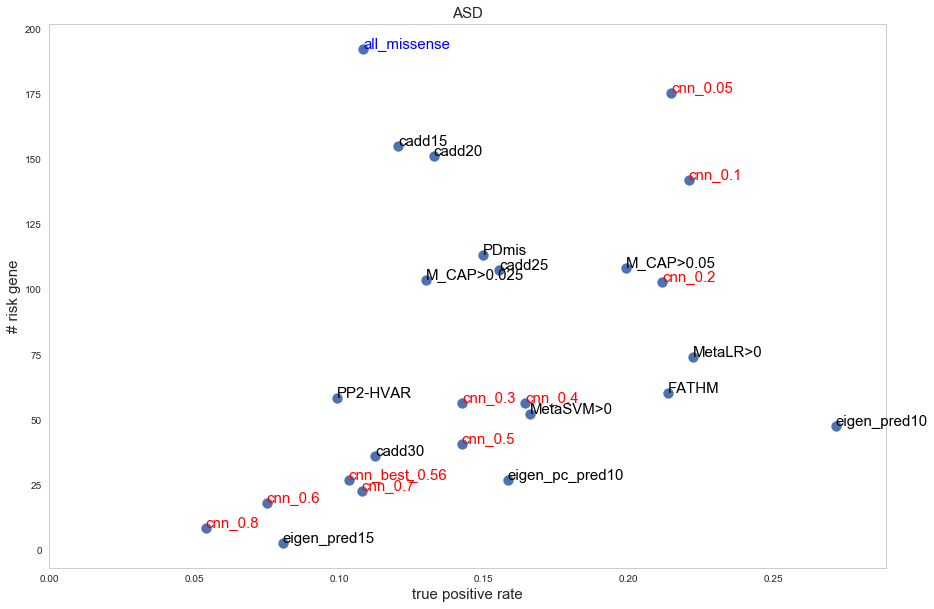

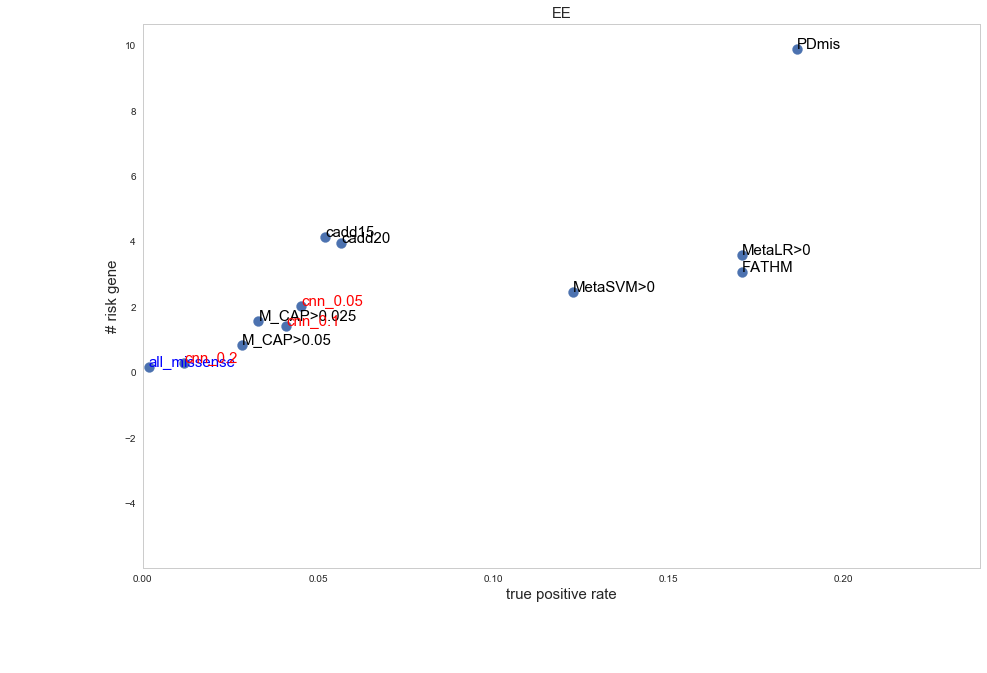

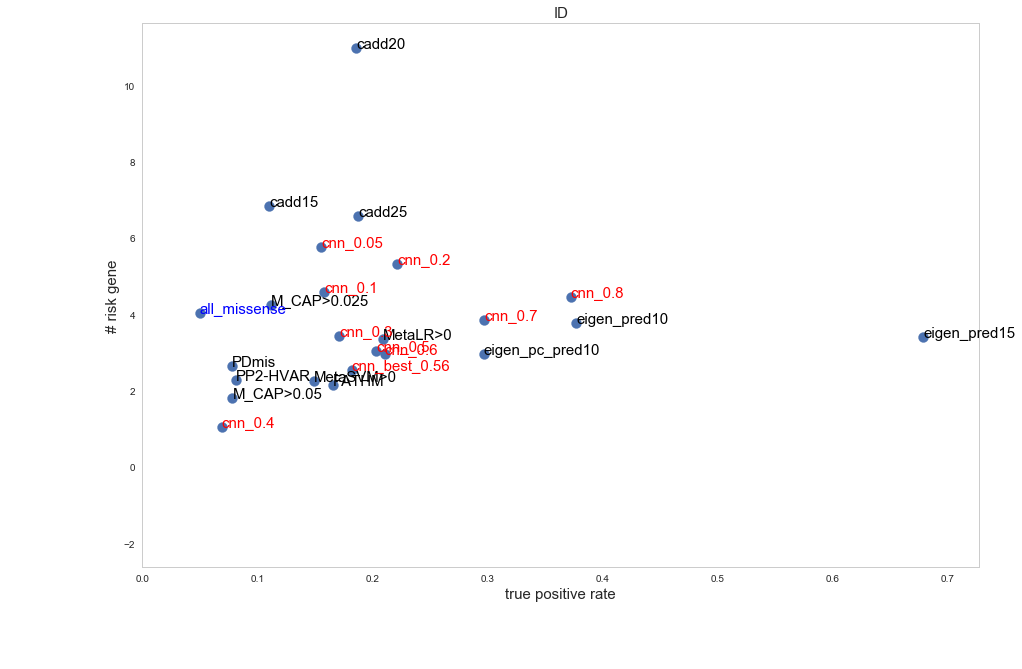

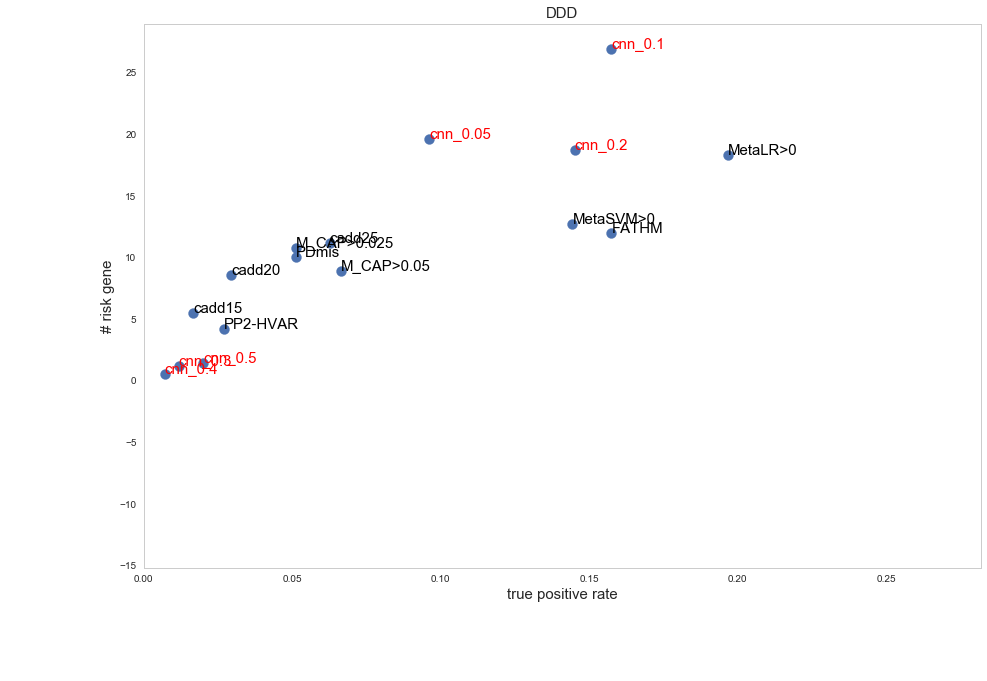

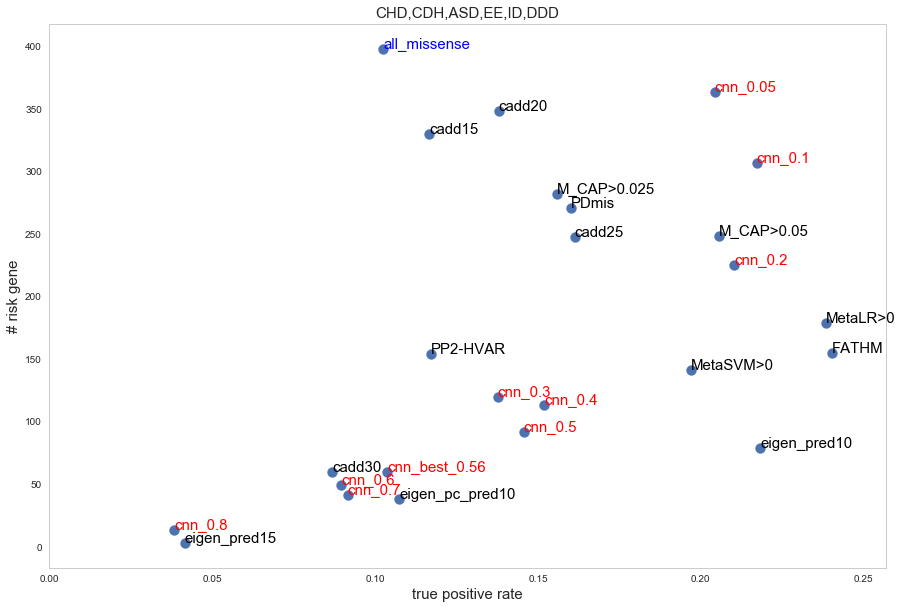

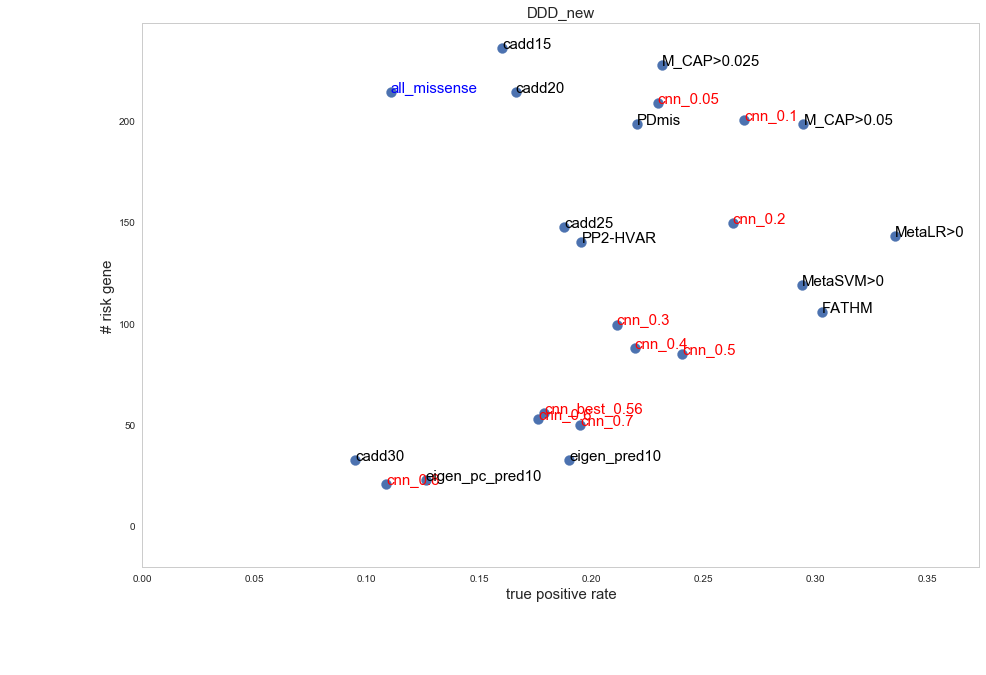

In [22]:
pli_5 = set(gene for gene, pli_score in pli.iteritems() if pli_score >= 0.5)
geneset = All_gene #All_gene #pli_5

disease_size = {'CHD':2779, 'CDH':378,'ASD':3953,'EE':264,'ID':192,
                'DDD_new':4293, 'DDD':1133, 'SSC':1911} 

# data is a little more than ANNOVAR annotatoin, do a comparison later
case_diseases = [['CHD'], ['CDH'], ['ASD'],['EE'], ['ID'], ['DDD'], 
                 ['CHD', 'CDH', 'ASD','EE', 'ID', 'DDD']]

for case_disease in case_diseases:

    fname = '../data/case_control/case.anno.rare.reformat.cnn.csv'
    df_case = pd.read_csv(fname)
    index = df_case['disease'].isin(case_disease) & df_case['genename'].isin(geneset) 
    df_case = df_case[index]
    case_info = (df_case, case_disease, disease_size)

    fname = '../data/case_control/control_1911.anno.rare.reformat.cnn.csv'
    control_disease = ['SSC']
    df_control = pd.read_csv(fname)
    index = df_control['disease'].isin(control_disease) & df_control['genename'].isin(geneset) 
    df_control = df_control[index]
    control_info = (df_control, control_disease, disease_size)
    df = display_enrichment(case_info, control_info, case_disease)
    
fname = '../data/case_control/DDD_new_0.2.anno.rare.reformat.cnn.csv'
case_disease = ['DDD_new']
df_case = pd.read_csv(fname)
index =  df_case['genename'].isin(geneset) 
df_case = df_case[index]
case_info = (df_case, case_disease, disease_size)

df = display_enrichment(case_info, control_info, case_disease)

# neuron distribution

In [15]:
fname = validation
neurons = ['neuron_0', 'neuron_1', 'neuron_2', 'neuron_3', 'cnn_prob']

df = pd.read_csv(fname)
df = df[df.training==0]
df_pos = df[df.target==1][neurons]
df_neg = df[df.target==0][neurons]


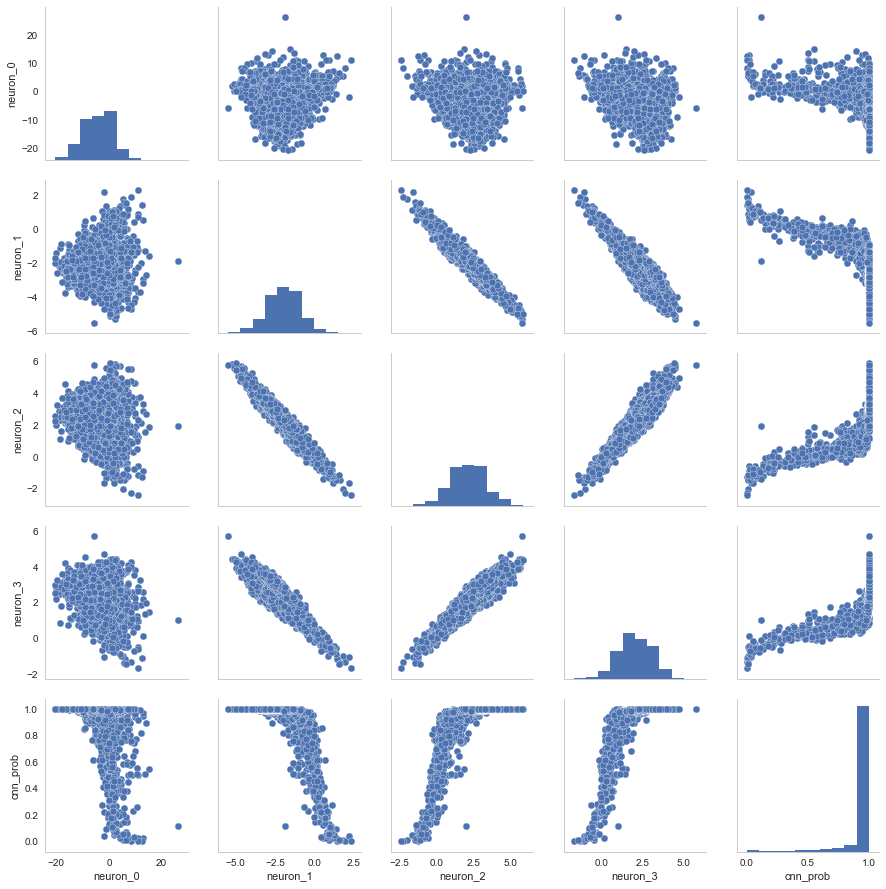

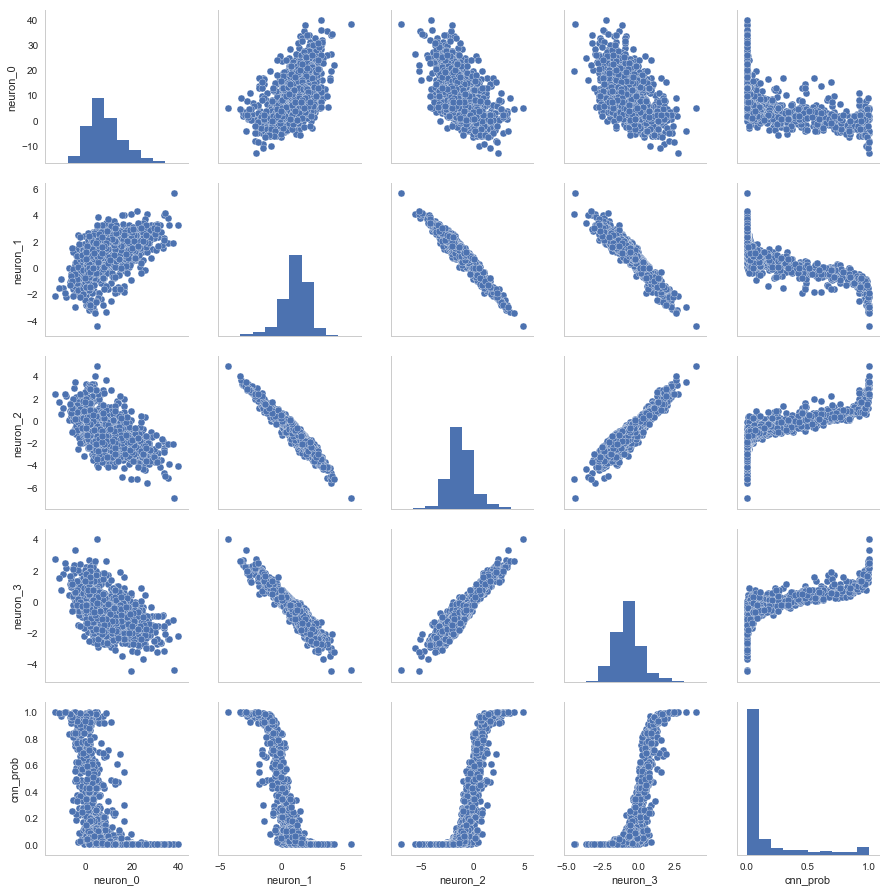

In [16]:
sns.pairplot(df_pos)
sns.pairplot(df_neg)

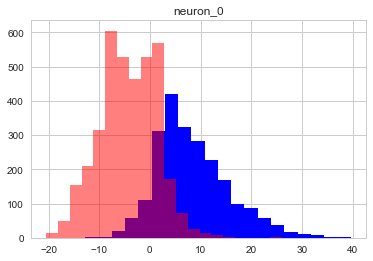

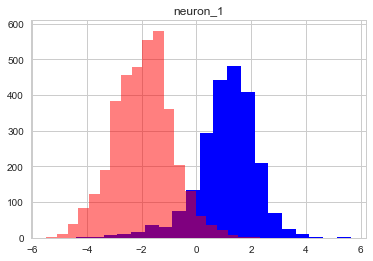

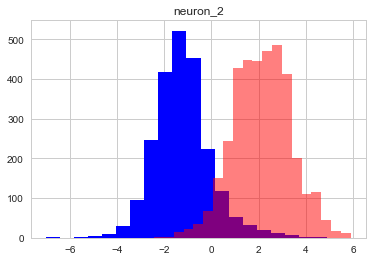

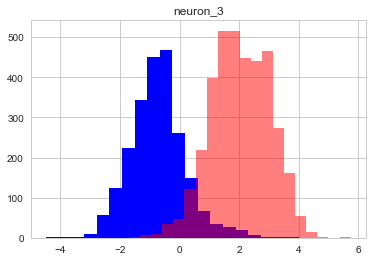

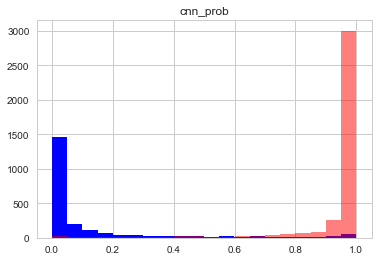

In [17]:
for neuron in neurons:
    fig, axs = plt.subplots()
    df_neg.hist(neuron, bins = 20, ax = axs, color = 'blue')
    df_pos.hist(neuron, bins = 20, ax = axs, color = 'red', alpha = 0.5) # cnn_prob
    

# training /test pli dist

../data/input_data.csv


/Users/hongjian/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (51,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


../data/ExAC_nonTCGA_missense_all.anno.rare_30000.reformat.csv
../data/case_control/control_1911.anno.rare.reformat.csv
../data/case_control/control_900.anno.rare.reformat.csv
../data/case_control/case.anno.rare.reformat.csv
../data/metaSVM/metaSVM_test1.anno.rare.reformat.csv
../data/metaSVM/metaSVM_test2.anno.rare.reformat.csv
../data/metaSVM/metaSVM_test3.anno.rare.reformat.csv
../data/metaSVM/metaSVM_addtest1.anno.rare.reformat.csv
../data/metaSVM/metaSVM_addtest2.anno.rare.reformat.csv
../data/metaSVM/metaSVM_train.anno.rare.reformat.csv


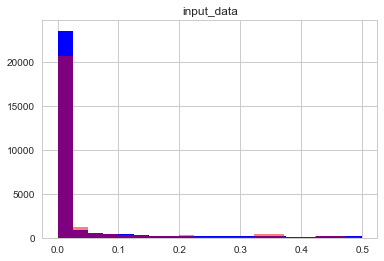

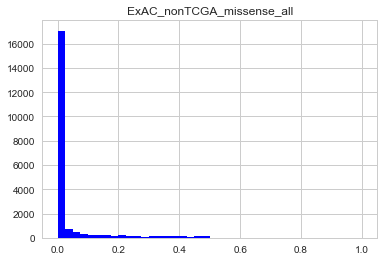

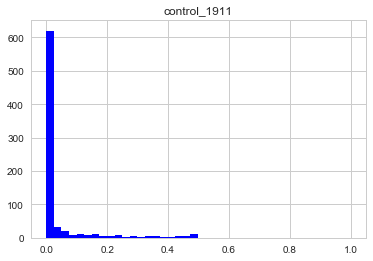

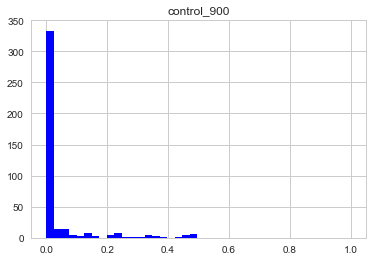

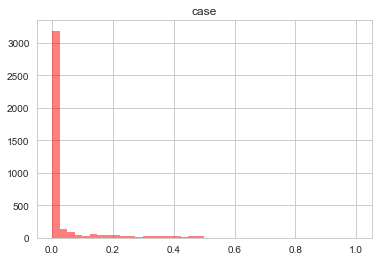

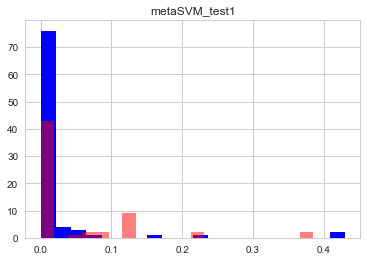

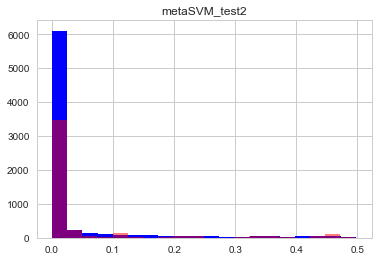

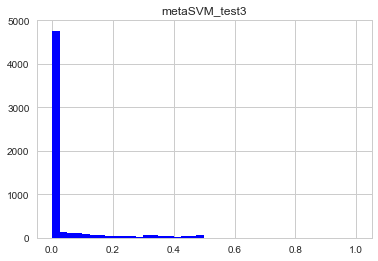

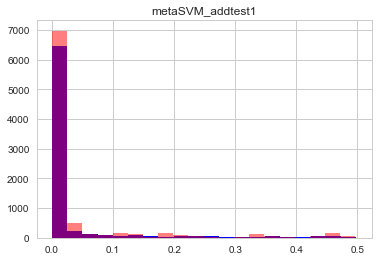

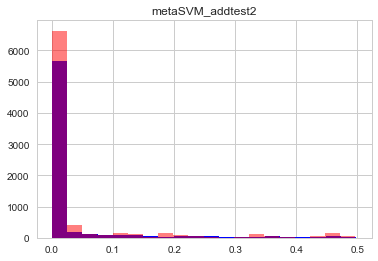

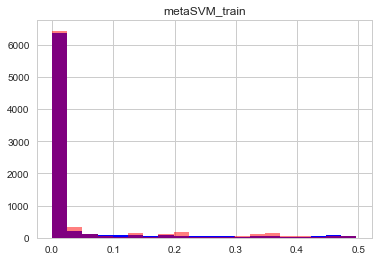

In [18]:
fins = ['../data/input_data.csv',
        '../data/ExAC_nonTCGA_missense_all.anno.rare_30000.reformat.csv',
        '../data/case_control/control_1911.anno.rare.reformat.csv', 
        '../data/case_control/control_900.anno.rare.reformat.csv', 
        '../data/case_control/case.anno.rare.reformat.csv', 
        '../data/metaSVM/metaSVM_test1.anno.rare.reformat.csv',
        '../data/metaSVM/metaSVM_test2.anno.rare.reformat.csv',
        '../data/metaSVM/metaSVM_test3.anno.rare.reformat.csv',
        '../data/metaSVM/metaSVM_addtest1.anno.rare.reformat.csv',
        '../data/metaSVM/metaSVM_addtest2.anno.rare.reformat.csv',
        '../data/metaSVM/metaSVM_train.anno.rare.reformat.csv']
for fin in fins:
    print fin
    
    df = pd.read_csv(fin)
    title = fin.split('/')[-1].split('.')[0]
    df_pos = df[df.target==1]
    df_neg = df[df.target==0]
    
    fig, axs = plt.subplots()
    df_neg.hist('pli', bins = 20, ax = axs, color = 'blue')
    df_pos.hist('pli', bins = 20, ax = axs, color = 'red', alpha = 0.5) # cnn_prob
    axs.set_title(title)

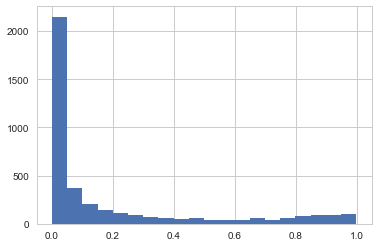

In [19]:
df = pd.read_csv('../data/case_control/case.anno.rare.reformat.cnn.csv')
df['cnn_prob'].hist(bins=20)

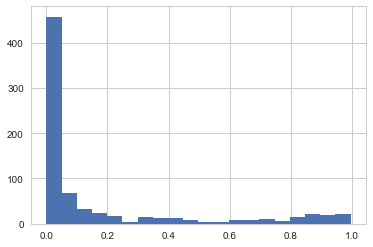

In [20]:
df = pd.read_csv('../data/case_control/control_1911.anno.rare.reformat.cnn.csv')
df['cnn_prob'].hist(bins=20)